# Solving BPDN$_\infty$ for quantized Compressed sensing via the cvxopt package

$\newcommand{\eps}{\varepsilon}$
$\newcommand{\bR}{\mathbb{R}}$
$\newcommand{\1}{{\rm 1}\kern-0.24em{\rm I}}$
$\newcommand{\inr}[1]{\bigl< #1 \bigr>}$

This notebooks is a simulations support for Section~4 of paper

> Sjoerd, Dirksen and Guillaume, Lecué and Holger, Rauhut, "ON THE GAP BETWEEN RIP-PROPERTIES AND SPARSE RECOVERY CONDITIONS"

We refer the reader to <a href="http://lecueguillaume.github.io/assets/gap_rip_reconstruction.pdf"> paper </a> for more details

In [1]:
from __future__ import division
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import cvxopt library for solving our optimization problem

In [2]:
from cvxopt import solvers, matrix, spdiag, log, spmatrix, sparse # writting '%pylab inline' after those lines will cause trouble in the matrix method

# Solving BPDN$_\infty$ via linear programming

Given a measurements matrix $A\in\bR^{m\times n}$ and $y=A\hat x + e$ where $||e||_\infty\leq \eps$, the Basis Pursuit Denoising program  BPDN$_\infty$ is the procedure

$$
min\big( ||t||_1: ||At-y||_\infty\leq \eps\big) \hspace{2cm} (P).
$$

This procedure can be recast as a linear program by introducing slack variables $z^+,z^-\in\bR^n$: problem~(P) is equivalent to

> $$\min_{z^+,z^-\in\bR^n} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$-\eps\leq [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right]-y\leq \eps$$

> and $$\left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0$$

This is a linear program:

> $$\min_{\left[\begin{array}{c} z^+\\ z^-\end{array}\right]\in\bR^{2n}} \inr{a,\left[\begin{array}{c} z^+\\ z^-\end{array}\right]}$$

> subject to $$ M \left[\begin{array}{c} z^+\\ z^-\end{array}\right] \leq b$$

where

$$a = \left[\begin{array}{c} \1 \\ \1 \end{array}\right],\hspace{1cm} M = \left[\begin{array}{c}[A|-A]\\ [-A|A]\\ [-I_n|0]\\ [0|-I_n] \end{array}\right],\hspace{1cm} b = \left[\begin{array}{c}y + \eps \1\\ -y+\eps\1 \\ 0 \\ 0 \end{array}\right]$$

Solution to (P) is recovered via $t= z^+-z^-$.

### construction of cvxopt matrices $a,M,b$

In [3]:
def cvx_mat(A, y, eps):
    '''A, y: numpy array or cvx matrices
    eps : positive real number'''
    A = matrix(A)
    y = matrix(y)
    m, n = matrix(A).size
    # matrix a
    a = matrix(ones(2*n))
    # matrix M
    I_n = spdiag([1]*n)
    z_n = spdiag([0]*n)
    M = matrix([[A,-A, -I_n, z_n],[-A, A, z_n, -I_n]])
    # matrix b
    un_m = matrix(ones(m))
    zero_n = matrix(zeros(n))
    b = matrix([y + eps*un_m, -y + eps*un_m, zero_n, zero_n])
    return a, M, b

### construction of sparse signals in $\bR^n$ and measurements in $\bR^m$

In [4]:
def signal(n, sparsity):
    sel = random.permutation(n)
    sel = sel[0:sparsity]   # indices of the nonzero elements of xsharp
    xsharp = zeros(n)
    xsharp[sel] = 1
    return xsharp

def measures(A, signal, eps):
    m, n = A.shape
    e = random.uniform(-eps, eps, (m,1))
    return [sum(a) for a in zip(dot(A, signal), e)]

In [13]:
m , n, sparsity, eps = 10, 30, 3, 0
A, x_hat = randn(m, n), signal(n, sparsity)
y = measures(A, x_hat, eps)

In [14]:
a, M, b = cvx_mat(A, y, eps)
#print(a, M, b)

### cvxopt linear solver  <a href="http://cvxopt.org/examples/tutorial/lp.html"> cvx lp </a>

In [15]:
sol = solvers.lp(a, M, b)
sol = sol['x']
x_recover = sol[0:n] - sol[n:2*n]

     pcost       dcost       gap    pres   dres   k/t
 0: -7.3969e-15  2.6645e-14  2e+02  1e+00  1e+00  1e+00
 1:  1.0175e+00  1.6355e+00  9e+00  1e-01  1e-01  7e-01
 2:  2.7481e+00  2.9466e+00  3e+00  4e-02  3e-02  2e-01
 3:  2.9303e+00  2.9436e+00  4e-01  6e-03  5e-03  2e-02
 4:  2.9993e+00  2.9994e+00  5e-03  7e-05  5e-05  2e-04
 5:  3.0000e+00  3.0000e+00  5e-05  7e-07  5e-07  2e-06
 6:  3.0000e+00  3.0000e+00  5e-07  7e-09  5e-09  2e-08
Optimal solution found.


In [16]:
norm(matrix(x_hat) - x_recover,2)

4.3543259337789098e-08

In [17]:
def dist(x_hat, sol):
    n = len(x_hat)
    x_recover = sol[0:n] - sol[n:2*n]
    return norm(matrix(x_hat) - x_recover,2)

# Phase transition diagram for BPDN$_\infty$

We say that the reconstruction is a success when $||x_{hat}-x_{recover}||_2\leq 10\eps + 0.001$

In [18]:
def phase_transition_mat(n, eps, nbtest):
    """return a n.n/2 matrix with the number of reconstruction success for every  1\leq m \leq n measurements 
    and sparsity 1\leq sparsity \leq n/2
    n : ambiant dimension of the signals
    eps : infinite norm of the additive noise (= twice the size of cells in CS quantization)
    nbtest : number of tests for each pixel"""
    PTM = zeros((n,int(n/2)))
    set_ind_failure = []
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A = randn(m,n) / sqrt(m)
        ind_failure = 0
        for sparsity in range(1,min(m+1, int(n/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                if dist(x_hat, sol) <= 10*eps+0.001:
                    nb_success = nb_success + 1
            PTM[m-1, sparsity-1] = nb_success
    return PTM

In [19]:
def frontier(mat):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    N = len(mat)
    for s in range(int(N/2)):
        P = 0
        while mat[P,s]<nbtest/2 and P<N-1:
            P = P + 1
        L.append(P)
    return L

In [24]:
n, eps, nbtest = 80, 0, 10
solvers.options['show_progress'] = False # No logs printed
mat = phase_transition_mat(n, eps, nbtest)# construction of the matrix with the number of success among nbtest

line number 20 done
line number 40 done
line number 60 done
line number 80 done


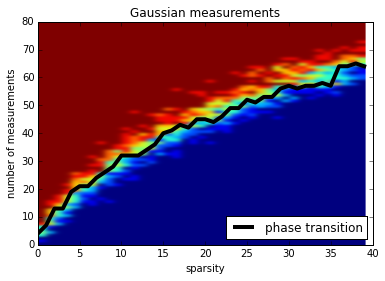

In [25]:
P_min, P_max, S_min, S_max = 0, n, 0, int(n/2)-1
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
titre = "Gaussian measurements"
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(n/2))
L = frontier(mat)
plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

#filename = 'noisy_gaussian_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

### repeat the construction of the frontier *nb_curves* times to "smooth it"

> nb_curves: number of phase transition curves constructed. Those curves are then averaged to "smooth" the effect of randomness in phase transition and get a "stable" phase transition

In [399]:
#n, eps, nbtest = 100, 0.1, 16
nb_curves = 40
L = zeros(int(n/2))
for i in range(nb_curves):
    if (i % 10) == 0:
        print('step {} done'.format(i))
    mat = phase_transition_mat(n, eps, nbtest)
    F = frontier(mat)
    L = [sum(a) for a in zip(L,F)] 
L_gauss = [i/nb_curves for i in L]

step 0 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done

In [403]:
#For next use, save the Gaussian phase transition frontier in a txt file 
filename = 'gaussian_phase_transition_quantized_cs_{}_eps_{}.txt'.format(n, eps)
with open(filename, "w") as f:
    for item in L_gauss:
        f.write('{}\n'.format(item))
f.close()

#import the phase transition from the file 'gaussian_phase_transition.txt'
#filename = 'gaussian_phase_transition_{}.txt'.format(N)
#with open(filename, "r") as inputfile:
#    L_gauss = list(csv.reader(inputfile))
#L_gauss = [int(float(ele[0])) for ele in L_gauss]

### Draw the phase transition frontier for quantized CS for Gaussian measurements

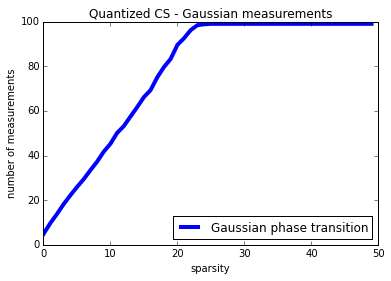

In [407]:
X = range(len(L_gauss))
plot(X,L_gauss, linewidth=4, color = 'blue', label="Gaussian phase transition")
titre = "Quantized CS - Gaussian measurements"
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.legend(loc=4)
filename = 'gaussian_phase_transition_quantized_cs_{}_eps_{}.png'.format(n, eps)
plt.savefig(filename,bbox_inches='tight')